# Simpson's paradox demonstrated on simulated data

This notebook contains code that demonstrates Simpson's paradox.
For the description of the paradox - cf. Wikipedia: https://en.wikipedia.org/wiki/Simpson%27s_paradox

Note, that nothing new is added to the general knowledge about the paradox by the analysis below. The paradox is only an excuse for writing some R code.

In [2]:
library(ggfortify)
library(tidyverse)
library(data.table)
library(magrittr)
library(broom)
library(nortest)
library(olsrr)

In [5]:
# 1. generate artificial data for this example ---------------------------------
# there will be three subgroups in the dataset
# 1.1. prepare three sets of parameters 
mRegParams1 <- c(0.5, 10, 0.5)
mRegParams2 <- c(0.25, 3, 0.75) 
mRegParams3 <- c(2.0, -30, 1.5)
# 1.2. prepare three sets of independent variable values
X_1 <- runif(n = 50, min = 0, max = 5)
X_2 <- runif(n = 50, min = 5, max = 10)
X_3 <- runif(n = 50, min = 10, max = 15)
# 1.3. calculate the dependent variable values for the three cases
mFunctionSim <- function(X_vec, dParams) {
  return(X_vec * dParams[[1]] + dParams[[2]] + rnorm(n = length(X_vec), sd = dParams[[3]]))
}
Y_1 <- mFunctionSim(X_vec = X_1, dParams = mRegParams1)
Y_2 <- mFunctionSim(X_vec = X_2, dParams = mRegParams2)
Y_3 <- mFunctionSim(X_vec = X_3, dParams = mRegParams3)
# 1.4. concatenate data into single data.table
dt1 <- data.table::data.table(y = Y_1, x = X_1, group_label = "A")
dt2 <- data.table::data.table(y = Y_2, x = X_2, group_label = "B")
dt3 <- data.table::data.table(y = Y_3, x = X_3, group_label = "C")
dtData <- data.table::rbindlist(l = list(dt1, dt2, dt3))

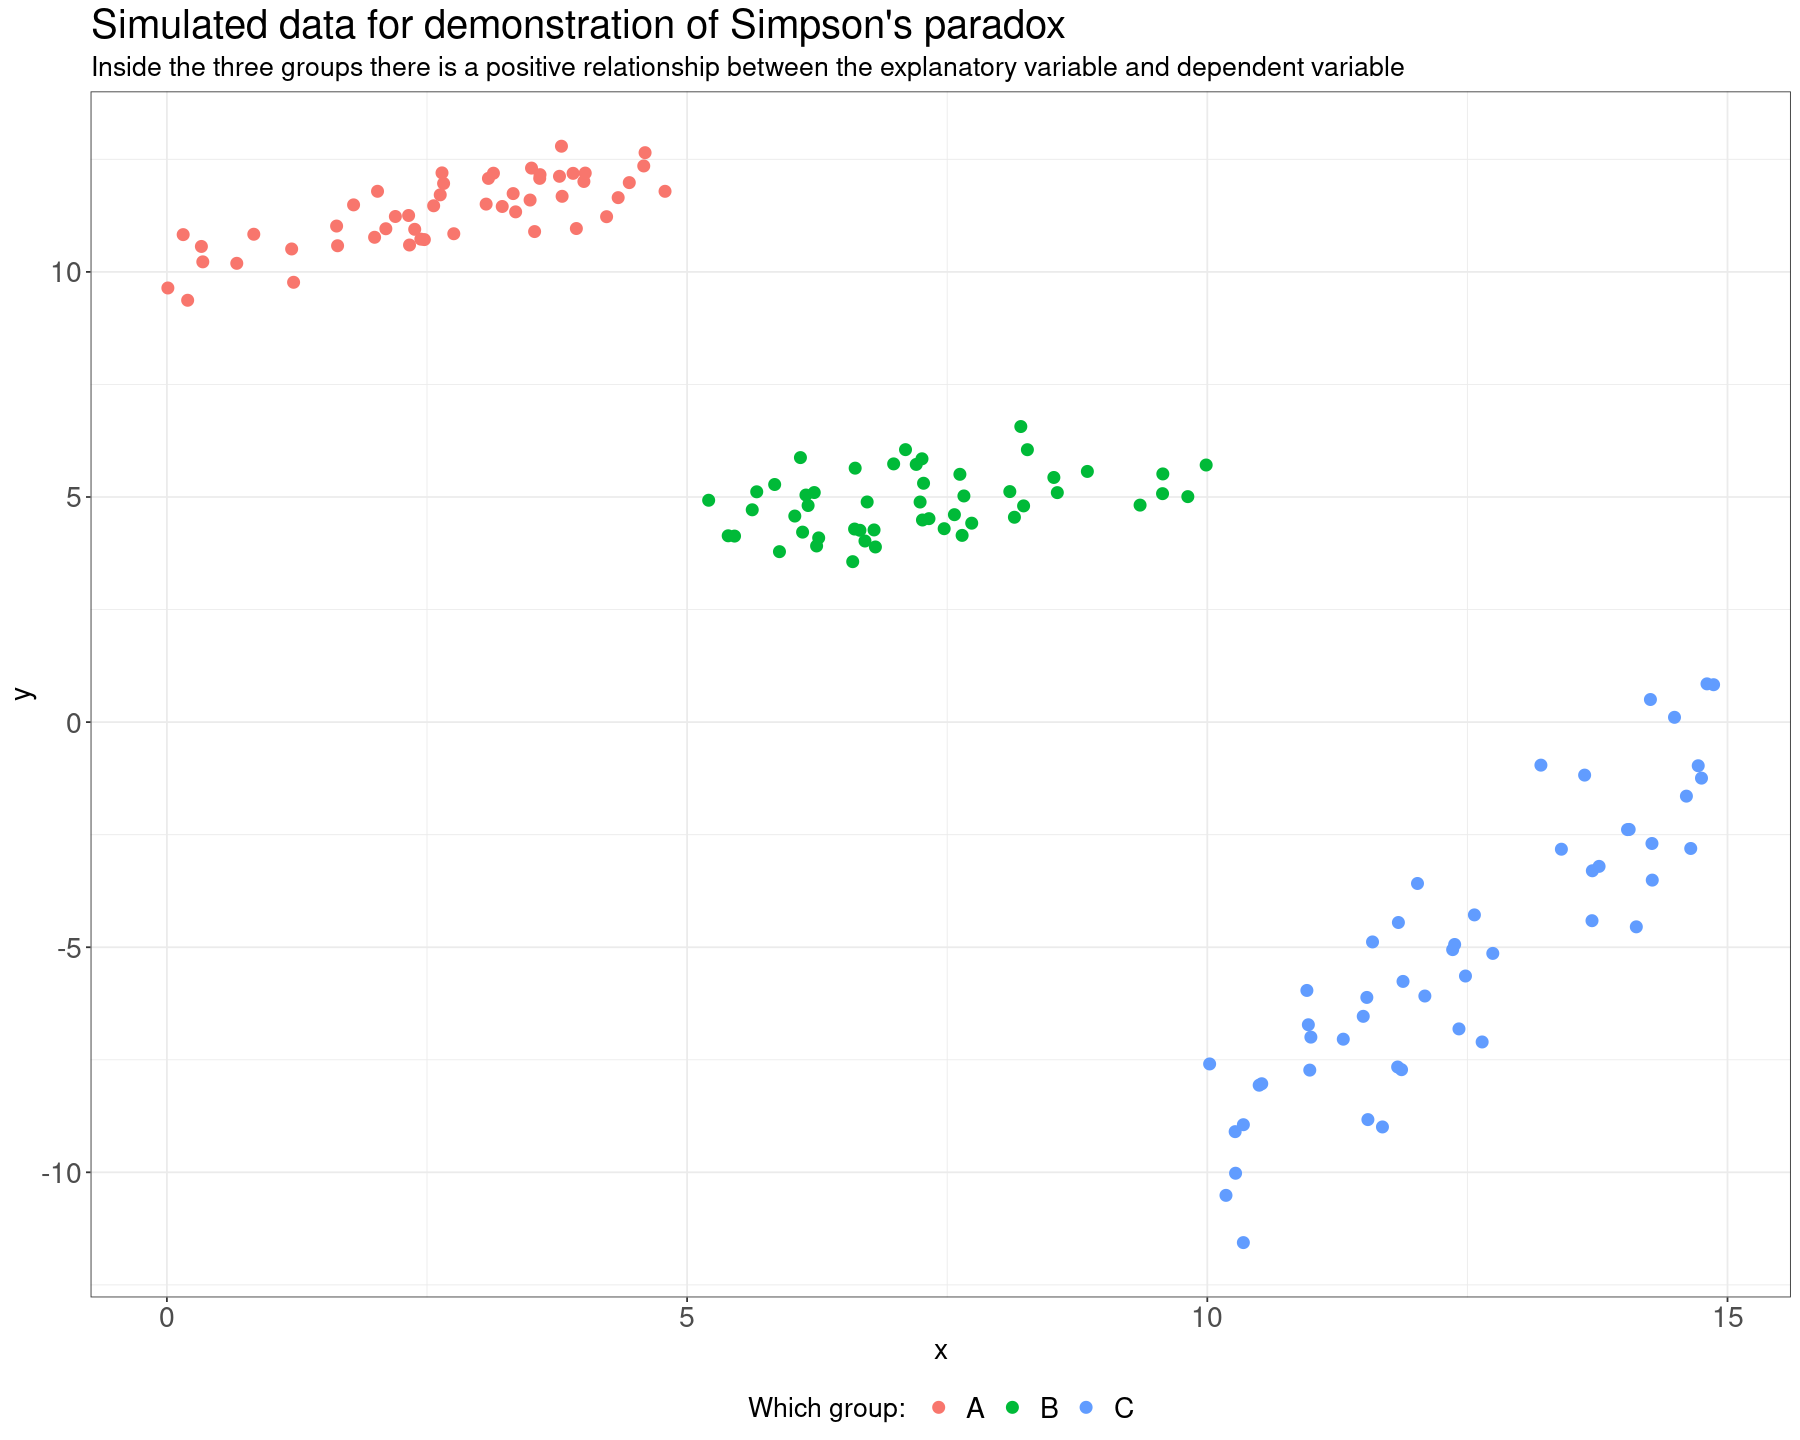

In [42]:
# 1.5. make a plot of the data to work with later on
options(repr.plot.width=15, repr.plot.height=12)
plotStdTheme <- theme(
      legend.position = "bottom",
      plot.title = element_text(size = 24),
      axis.title = element_text(size = 17),
      legend.text = element_text(size = 17),
      plot.subtitle = element_text(size = 16),
      legend.title = element_text(size = 16),
      axis.text = element_text(size = 17)
  ) 
plotOfSimData <- ggplot(data = dtData, aes(x = x, y = y, color = group_label)) + 
  geom_point(size = 3) + theme_bw() + 
  theme(
      legend.position = "bottom",
      plot.title = element_text(size = 24),
      axis.title = element_text(size = 17),
      legend.text = element_text(size = 17),
      plot.subtitle = element_text(size = 16),
      legend.title = element_text(size = 16),
      axis.text = element_text(size = 17)
  ) + plotStdTheme +
  ggtitle(
      label = "Simulated data for demonstration of Simpson's paradox",
      subtitle = "Inside the three groups there is a positive relationship between the explanatory variable and dependent variable"
  ) +
  scale_color_discrete(name = "Which group: ")
plotOfSimData

In [23]:
# 2. fit the model on the whole dataset ----------------------------------------
# 2.1. fit the model and view some characteristics
modelFullDataset <- lm(formula = y ~ x, data = dtData)
View(broom::tidy(modelFullDataset))
View(broom::glance(x = modelFullDataset))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),14.280750,0.6125134,23.31500,2.080529e-51
x,-1.415716,0.0714750,-19.80714,1.851459e-43


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.7260897,0.724239,3.691665,392.3229,1.851459e-43,1,-407.7457,821.4914,830.5233,2017.002,148,150


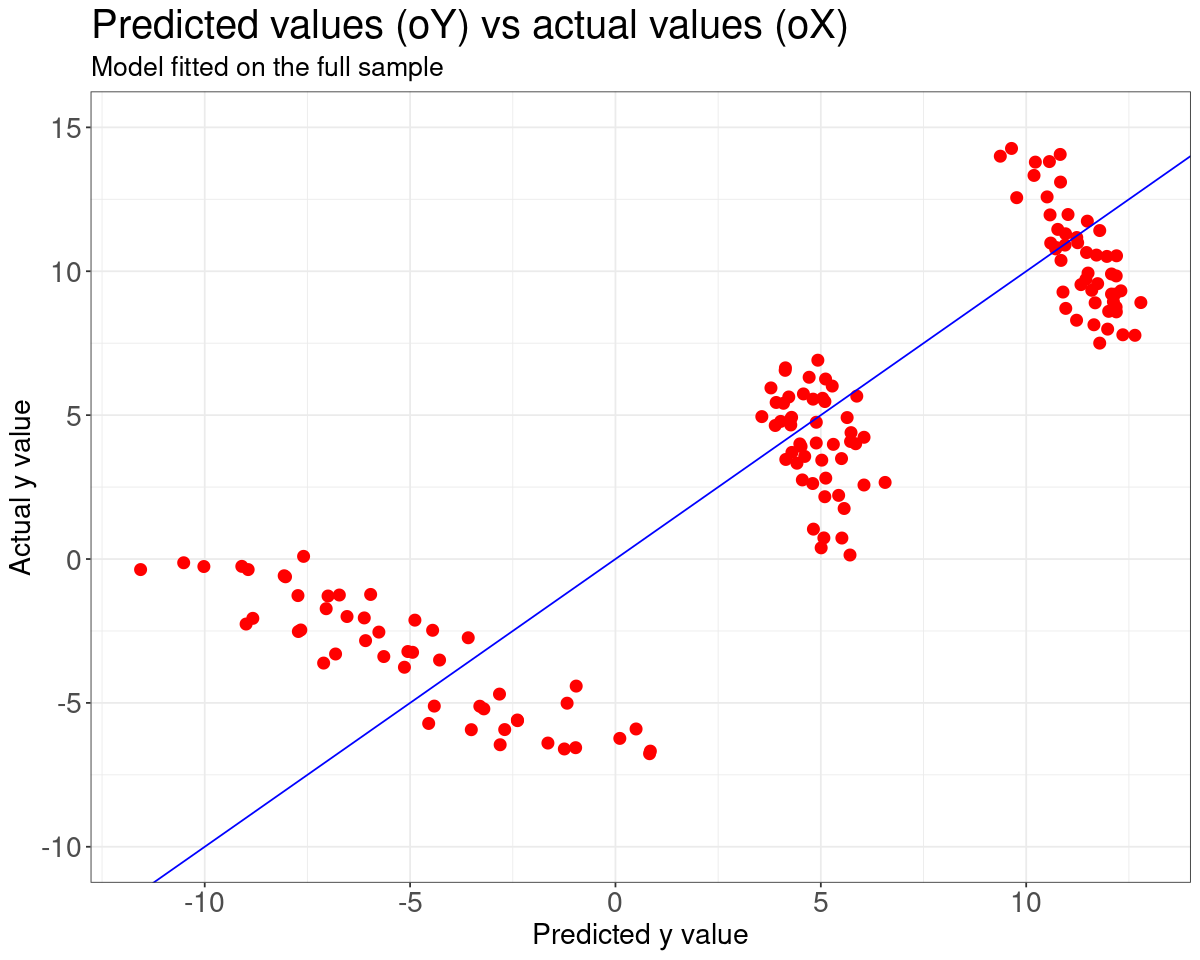

In [35]:
# 2.2. make predictions with the fitted model
dtData[, pred_fulldataset := predict(modelFullDataset, dtData)]
# 2.3. plot predictions against actual values
plotPredVsActualFullDataset <- 
  ggplot(data = dtData, mapping = aes(x = y, y = pred_fulldataset)) + 
  geom_point(color = "red", size = 3) + geom_abline(color = "blue") + theme_bw() + 
  ggtitle(label = "Predicted values (oY) vs actual values (oX)", 
          subtitle = "Model fitted on the full sample") +
  xlab("Predicted y value") + ylab("Actual y value") +
  ylim(-10, 15) + 
  plotStdTheme
options(repr.plot.width=10, repr.plot.height=8)
plotPredVsActualFullDataset

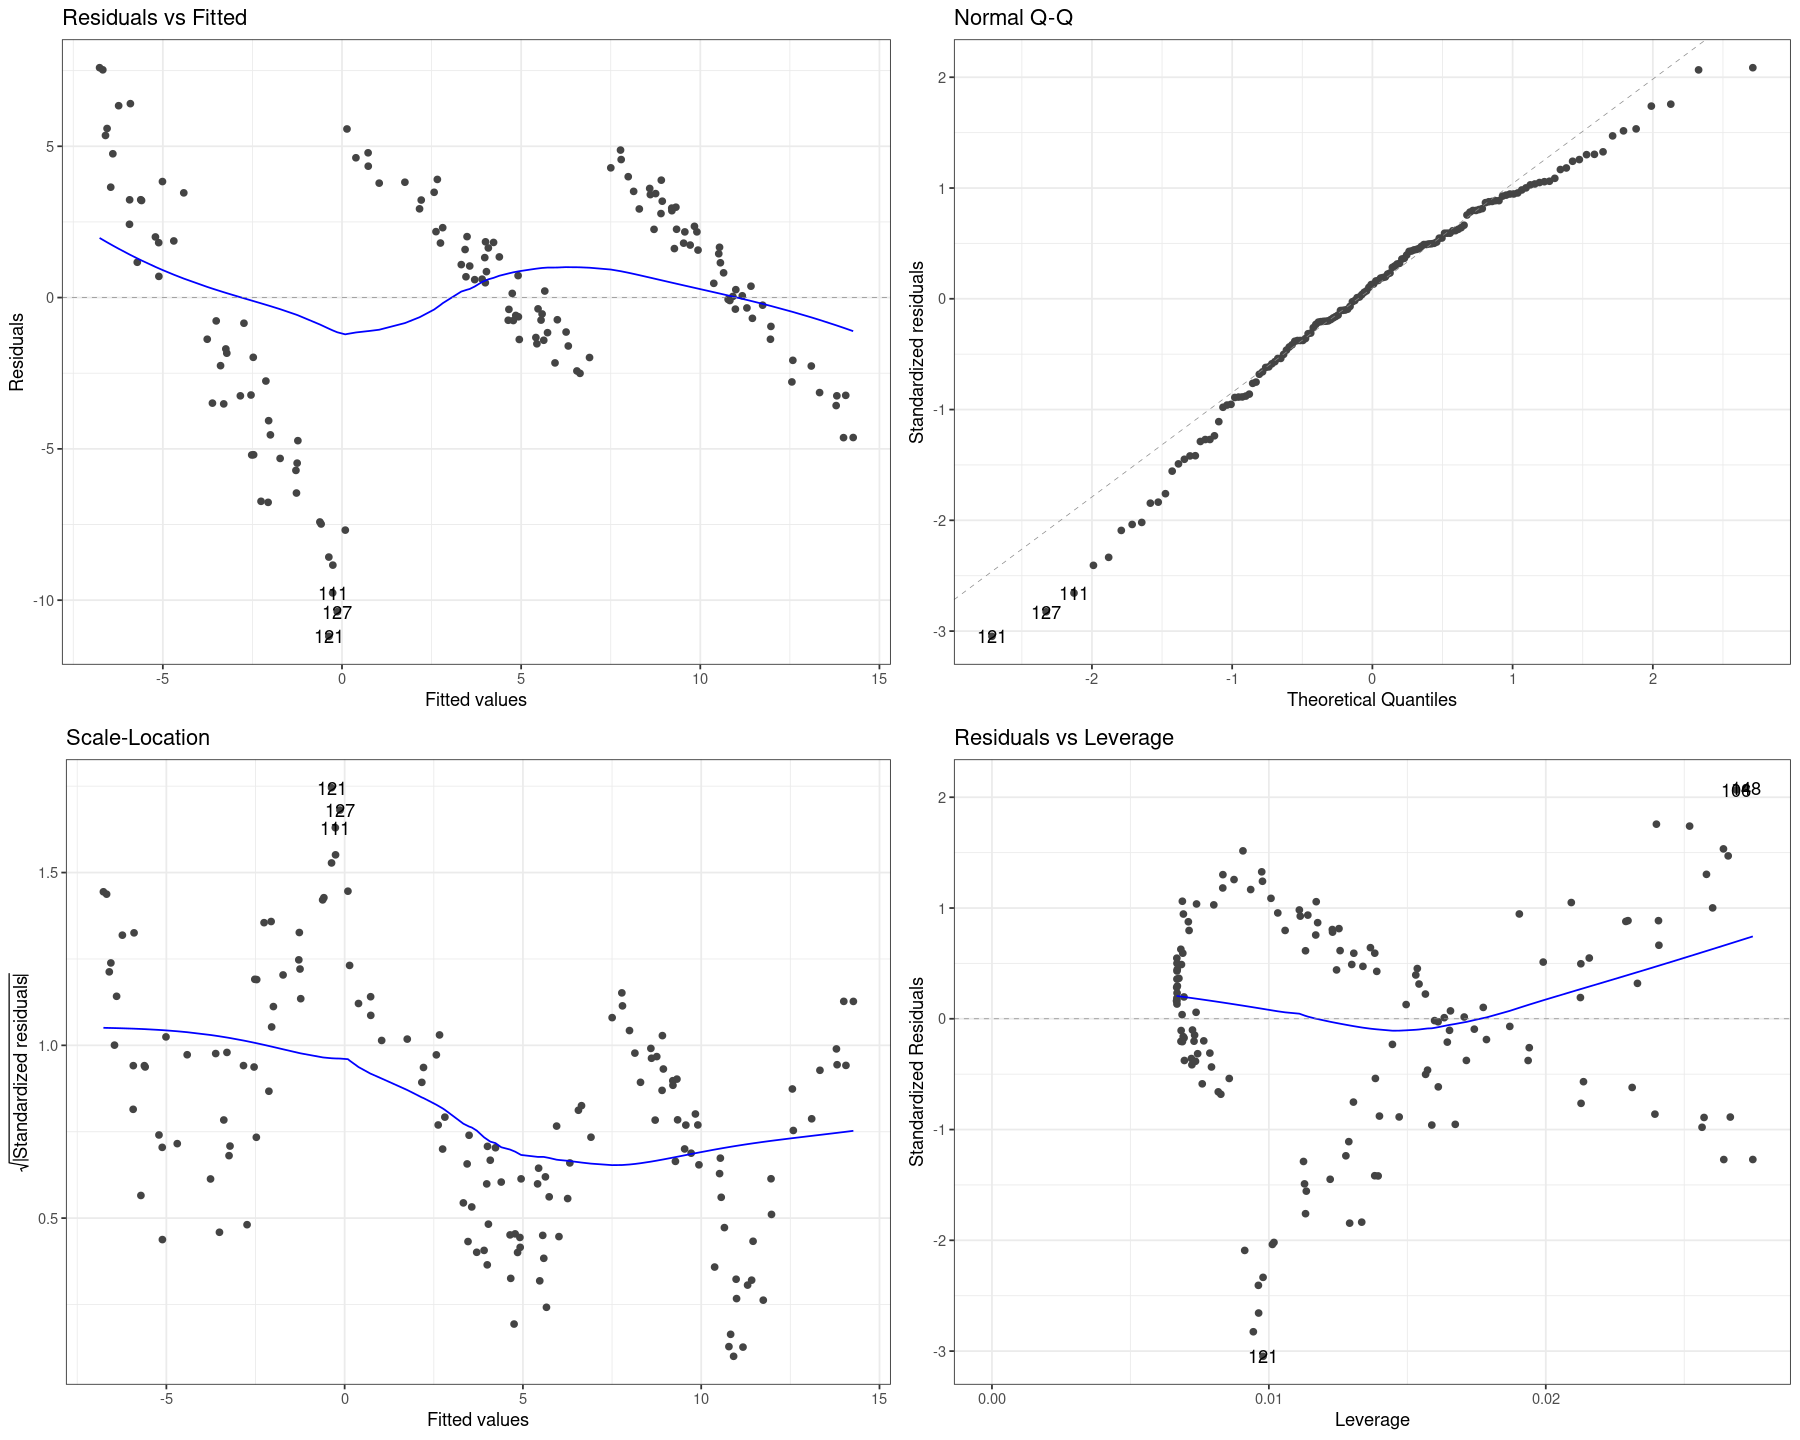

In [37]:
# 2.4. generating plots using autoplot
options(repr.plot.width=15, repr.plot.height=12)
autoplot(object = modelFullDataset) + theme_bw()

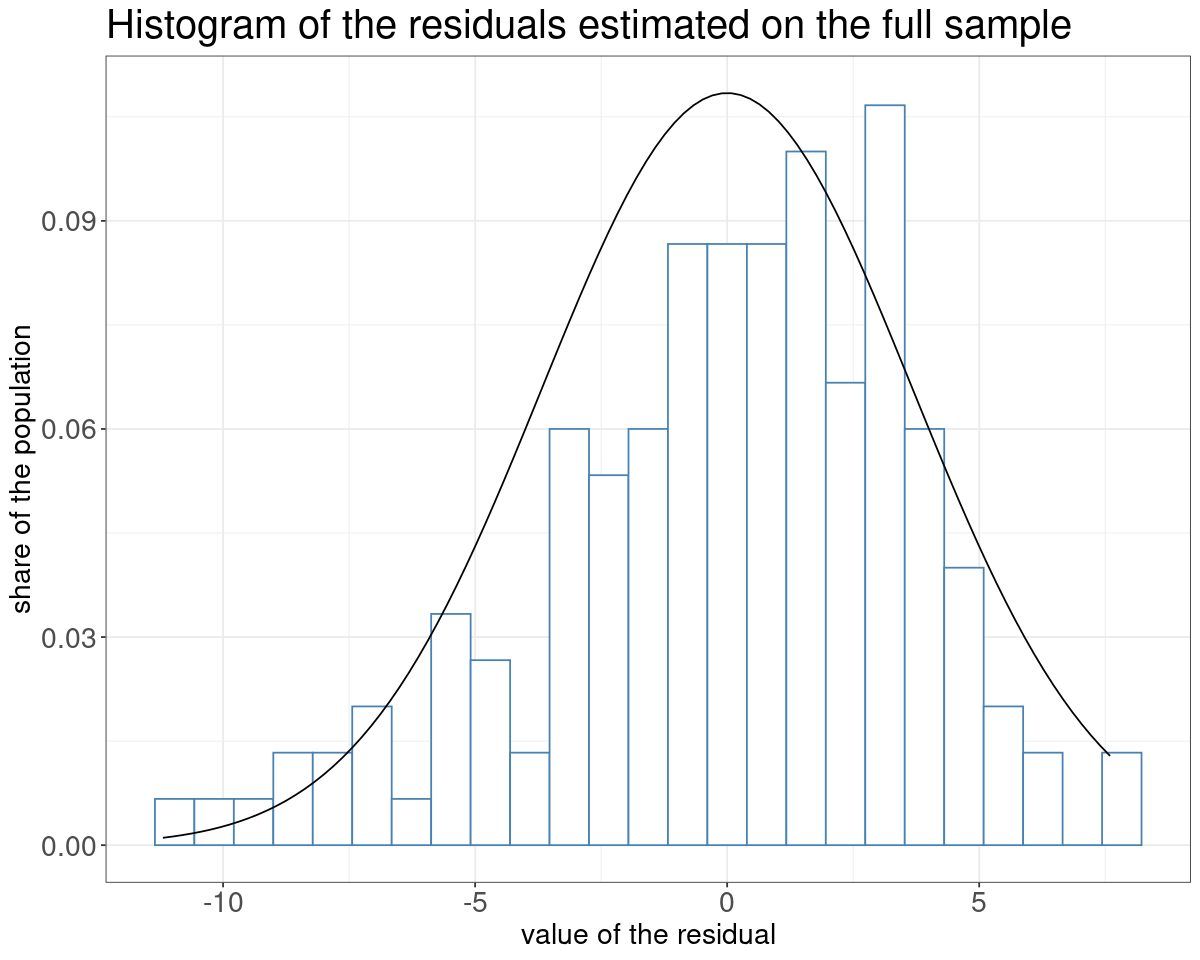

In [43]:
# 2.5. make histogram of residuals
dResids <- broom::augment(modelFullDataset) %>% dplyr::pull(.resid)
dtResids <- data.table::data.table(residual_value = dResids)
plotResidsFulldataset <- ggplot(data = dtResids, aes(x = residual_value)) +
  geom_histogram(aes(y = ..count../sum(..count..)), 
                 color = "steelblue", fill = "white", bins = 25) + theme_bw() +
  xlab("value of the residual") + ylab("share of the population") +
  ggtitle(label = "Histogram of the residuals estimated on the full sample")
# 2.6. upgrade histogram to include the density of the fitted normal dist
dGrid <- seq(min(dResids), max(dResids), (max(dResids) - min(dResids)) / 100)
dDensity <- dnorm(x = dGrid, mean = mean(dResids), sd = sd(dResids))
dtDensity <- data.table::data.table(x_val = dGrid, y_val = dDensity)
plotResidsFulldataset <- plotResidsFulldataset + 
  geom_line(data = dtDensity, mapping = aes(x = x_val, y = y_val)) +
  plotStdTheme
options(repr.plot.width=10, repr.plot.height=8)
plotResidsFulldataset

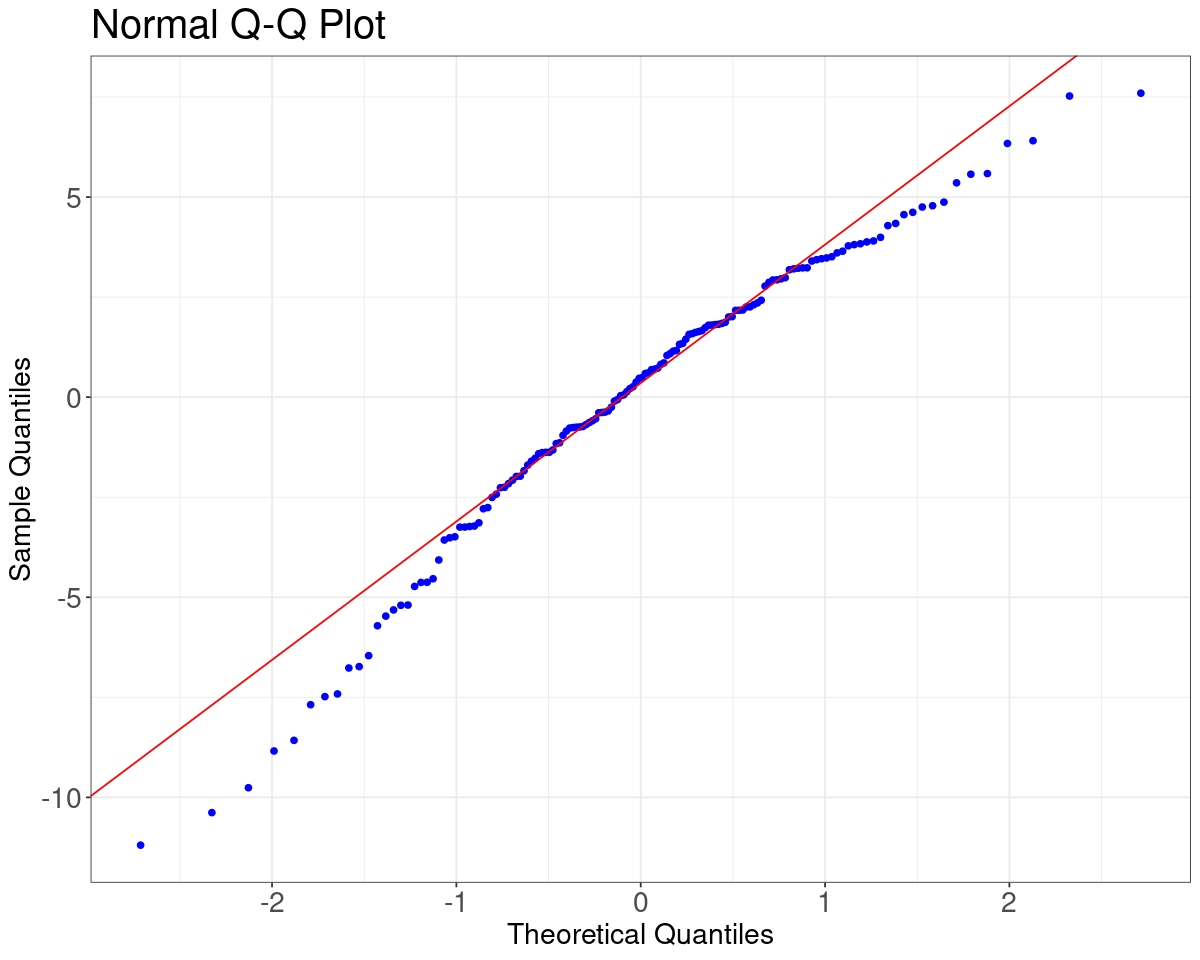

In [45]:
# 3. residuals diagnostics: check if residuals are normally distributed --------
# 3.0. make the qq plot to check if residuals are normally distributed
qqPlotResidsFullDataset <-
  olsrr::ols_plot_resid_qq(model = modelFullDataset, print = F) + theme_bw() + plotStdTheme
qqPlotResidsFullDataset

In [46]:
# 3.1. Shapiro - Wilk test
stats::shapiro.test(x = dResids)


	Shapiro-Wilk normality test

data:  dResids
W = 0.96904, p-value = 0.001834


In [47]:
# 3.2. Liliefors test (K-S test adjusted for the fact that estimation is 
# of normal dist's parameters is based on the sample)
nortest::lillie.test(x = dResids)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  dResids
D = 0.070292, p-value = 0.06705


In [48]:
# 3.3. Anderson-Darling test
nortest::ad.test(x = dResids)


	Anderson-Darling normality test

data:  dResids
A = 1.2912, p-value = 0.002279


In [49]:
# 3.4. Cramer-von-Mises test
nortest::cvm.test(x = dResids)


	Cramer-von Mises normality test

data:  dResids
W = 0.20028, p-value = 0.005239


In [50]:
# 3.5. running all the tests jointly using the olsrr package
res <- olsrr::ols_test_normality(y = dResids)
res

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.969          0.0018 
Kolmogorov-Smirnov        0.0703         0.4489 
Cramer-von Mises          9.9722         0.0000 
Anderson-Darling          1.2912         0.0023 
-----------------------------------------------

In [51]:
# 5. fit the model on the subsets of the data set ------------------------------
# 5.1. models fitting and parameters comparison
model_groupA <- lm(formula = y ~ x, data = dt1)
model_groupB <- lm(formula = y ~ x, data = dt2)
model_groupC <- lm(formula = y ~ x, data = dt3)
dtDataPredictionA <- 
  data.table::data.table(x_val = dt1$x, y_val = predict(model_groupA, dt1),
                         which_reg = "subset A regression")
dtDataPredictionB <- 
  data.table::data.table(x_val = dt2$x, y_val = predict(model_groupB, dt2),
                         which_reg = "subset B regression")
dtDataPredictionC <- 
  data.table::data.table(x_val = dt3$x, y_val = predict(model_groupC, dt3),
                         which_reg = "subset C regression")
dtBySubsetPred <- data.table::rbindlist(l = list(
  dtDataPredictionA, dtDataPredictionB, dtDataPredictionC))

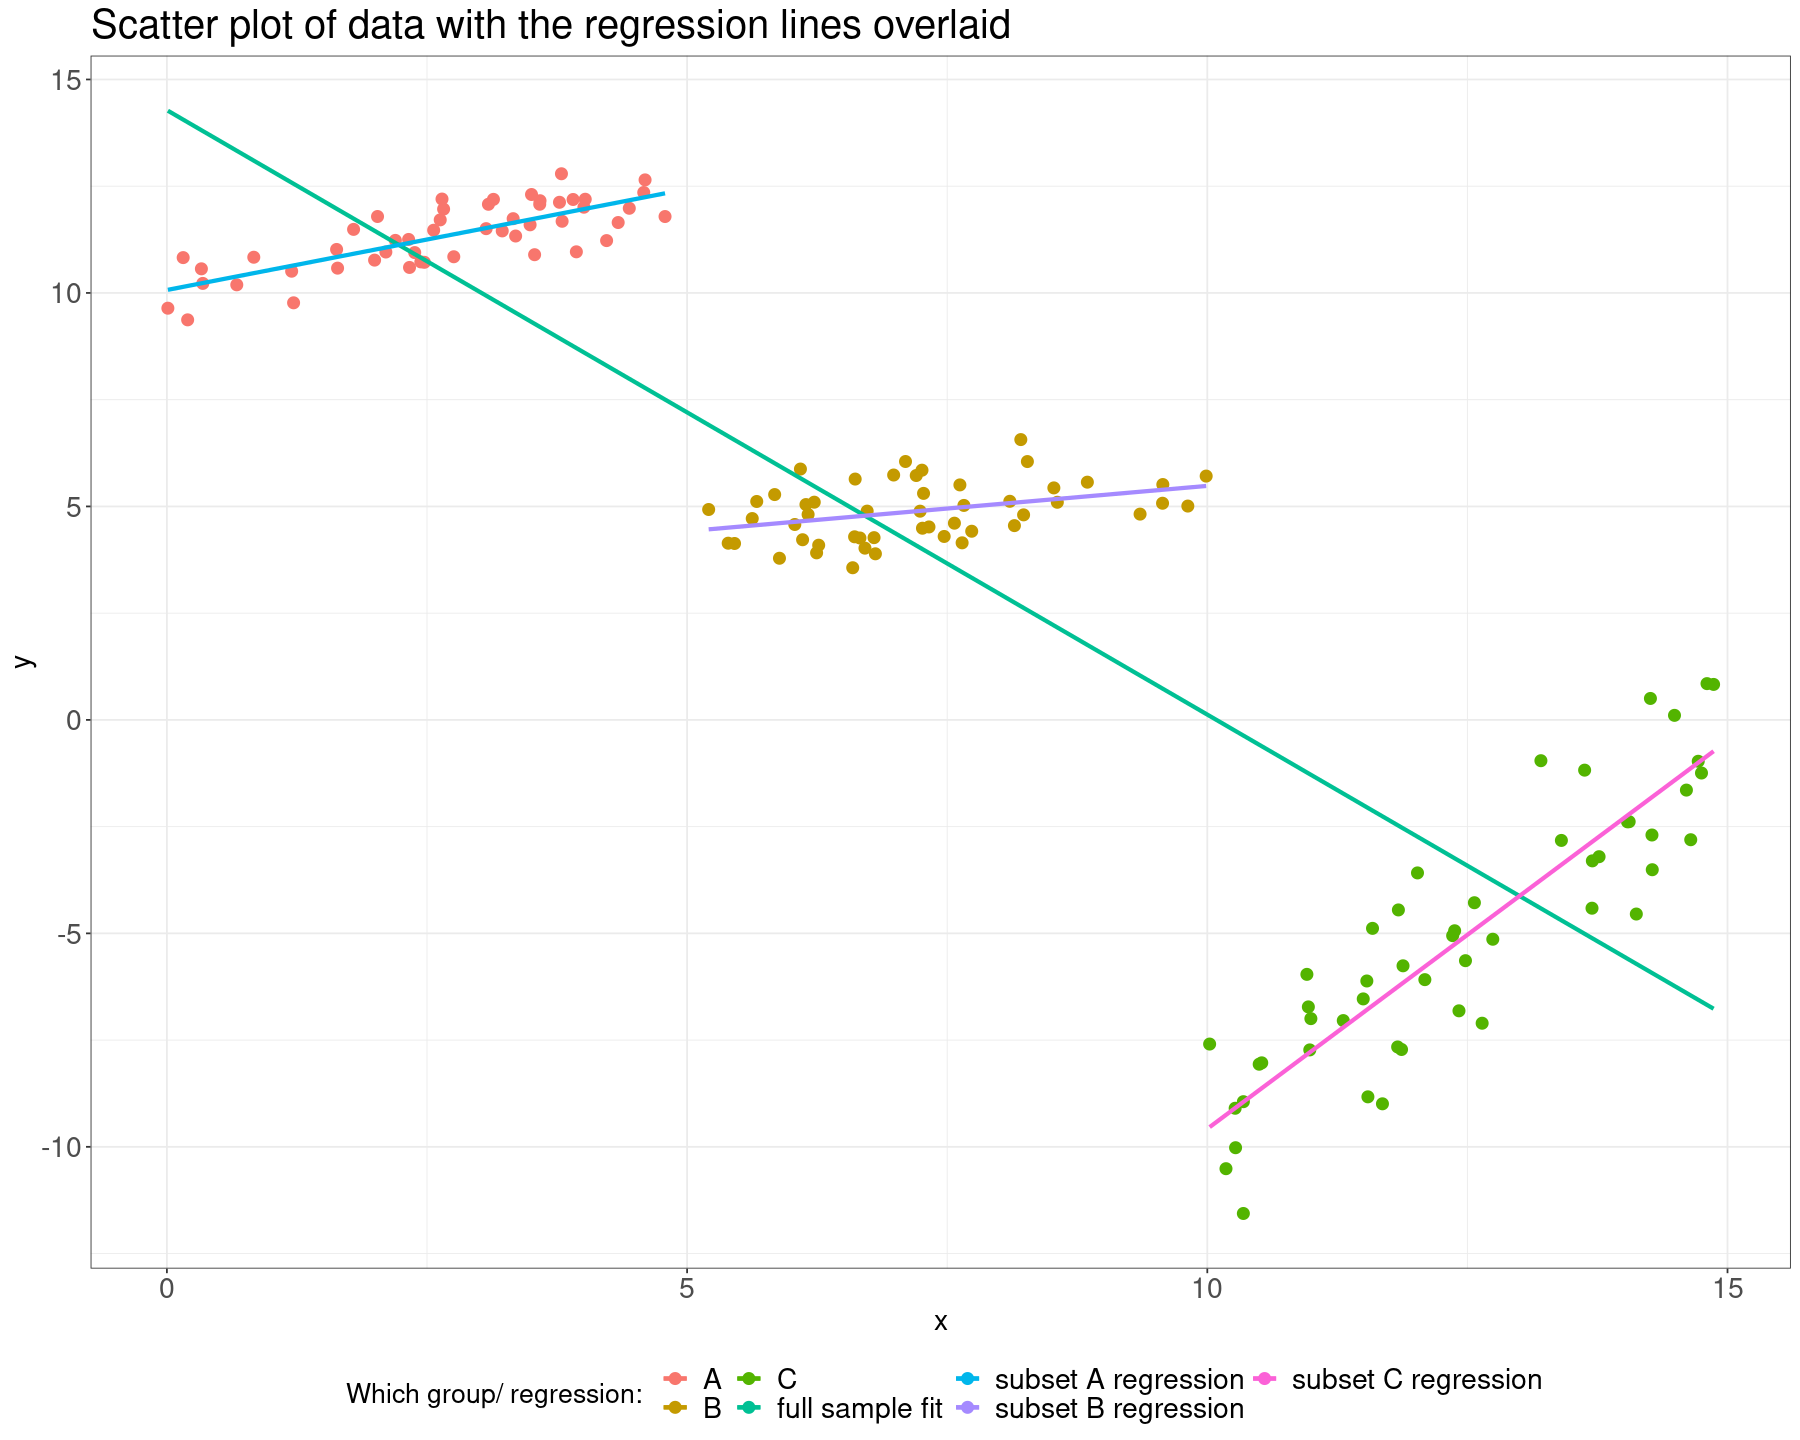

In [62]:
# 5.2. plot data points with one model fitted to the whole dataset and colors
dtDataPredictionFull <- 
  data.table::data.table(x_axis = dtData$x, y_axis = dtData$pred_fulldataset, 
                         categ_name = "full sample fit")
options(repr.plot.width=15, repr.plot.height=12)
plotOfSimData2 <- ggplot(data = dtData, aes(x = x, y = y, color = group_label)) + 
  geom_point(size = 3) + theme_bw() +
  ggtitle(label = "Simulated data for demonstration of Simpson's paradox") +
  scale_color_discrete(name = "Which group/ regression: ") +
  geom_line(data = dtDataPredictionFull, mapping = aes(
    x = x_axis, y = y_axis, color = categ_name), size = 1.2) +
  geom_line(data = dtBySubsetPred, mapping = aes(x = x_val, y = y_val, color = which_reg), size = 1.2) +
  ggtitle(label = "Scatter plot of data with the regression lines overlaid") + plotStdTheme
plotOfSimData2 

In [63]:
# 5.3. diagnostics of the model for group 'C'
# 5.3.1. view fitted model parameters
View(broom::tidy(model_groupC))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-27.753699,1.6676128,-16.64277,1.436945e-21
x,1.817552,0.1326707,13.69972,3.313250e-18


In [64]:
# 5.3.2. view model diagnostics 
View(broom::glance(x = model_groupC))

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.7963361,0.7920931,1.414374,187.6824,3.31325e-18,1,-87.26072,180.5214,186.2575,96.02177,48,50


In [65]:
# 5.3.3. residuals diagnostics - normality tests
dResidsC <- broom::augment(x = model_groupC) %>% pull(.resid)
olsrr::ols_test_normality(y = dResidsC)

-----------------------------------------------
       Test             Statistic       pvalue  
-----------------------------------------------
Shapiro-Wilk              0.9736         0.3215 
Kolmogorov-Smirnov        0.0817         0.8656 
Cramer-von Mises          3.263          0.0000 
Anderson-Darling          0.3502         0.4586 
-----------------------------------------------

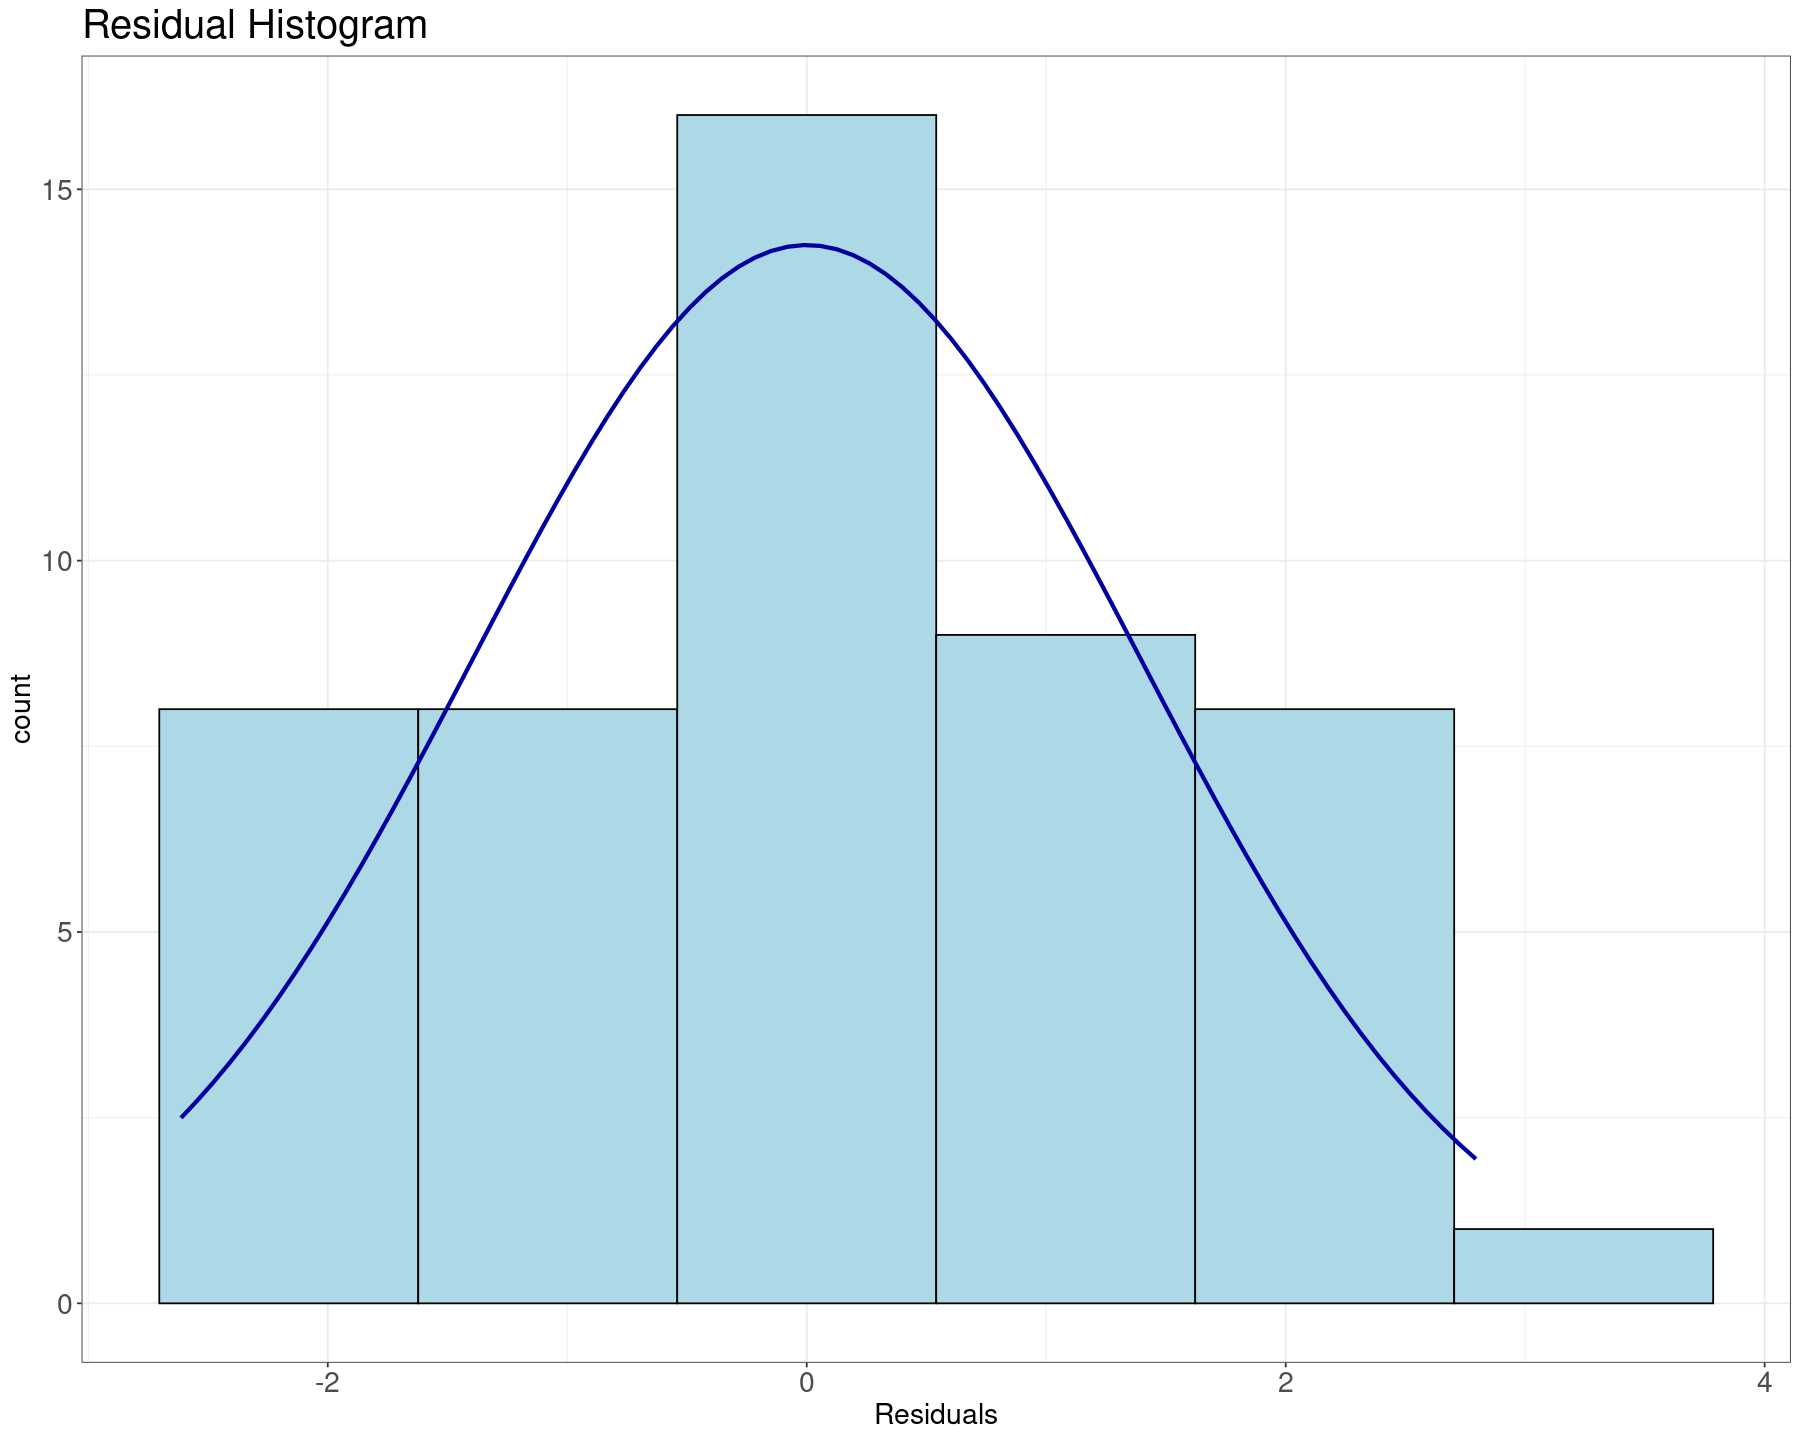

In [68]:
# 5.3.4. plot of residuals histogram
olsrr::ols_plot_resid_hist(model = model_groupC, print = F) + theme_bw() + plotStdTheme